In [1]:
import numpy as np
import pandas as pd 
from collections import Counter

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import torch
from fastai.vision import *
from fastai.metrics import *

np.random.seed(7)
torch.cuda.manual_seed_all(7)

In [2]:
import os
print(os.listdir("../input"))

['test', 'train']


In [3]:
train = pd.read_csv('../input/train/train.csv')
sub_file = pd.read_csv("../input/test/test.csv")
data_folder = Path("../input")

In [4]:
train.head()

,id,label
0,1,9
1,2,0
2,3,0
3,4,3
4,5,0


In [28]:
train.label.value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

![](https://i.ibb.co/WK5JN5w/Capture.png)

In [5]:
sub_file.head()

,id
0,60001
1,60002
2,60003
3,60004
4,60005


In [8]:
test_img = ImageList.from_df(sub_file, path=data_folder/'test', folder='test', suffix='.png')

databunch = ImageList.from_df(train, path=data_folder/'train', folder='train', suffix='.png')\
            .split_by_rand_pct(0.1)\
            .label_from_df()\
            .add_test(test_img)\
            .transform(get_transforms(do_flip=True), size=28)\
            .databunch(path='.', bs=128, device= torch.device('cuda:0'))\
            .normalize(mnist_stats)

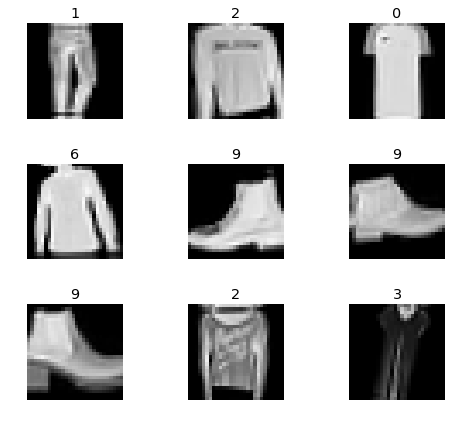

In [9]:
databunch.show_batch(rows=3, figsize=(7,6))

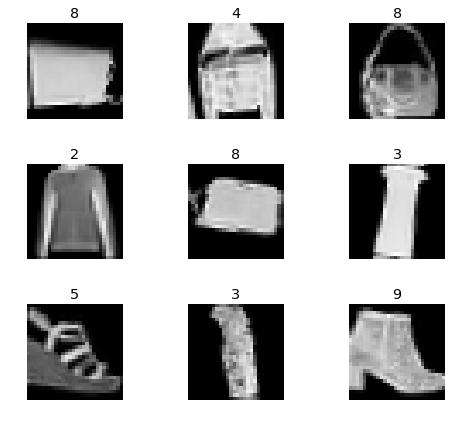

In [39]:
databunch.show_batch(rows=3, figsize=(7,6), is_train=False)

In [10]:
databunch.classes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [11]:
databunch.label_list

LabelLists;

Train: LabelList (54000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
9,0,0,3,0
Path: ../input/train;

Valid: LabelList (6000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
3,7,2,9,3
Path: ../input/train;

Test: LabelList (10000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: EmptyLabelList
,,,,
Path: ../input/train

In [15]:
databunch.train_ds[0][0]

In [16]:
databunch.valid_ds[0][0]

In [18]:
databunch.test_ds[0][0]

In [38]:
train_classes = Counter(databunch.train_ds.y)
train_classes.most_common()

[(Category 0, 5442),
 (Category 3, 5431),
 (Category 9, 5409),
 (Category 7, 5402),
 (Category 4, 5400),
 (Category 2, 5399),
 (Category 8, 5399),
 (Category 1, 5384),
 (Category 6, 5375),
 (Category 5, 5359)]

In [82]:
train_classes = {k: (v/54000)*100 for k, v in train_classes.items()}
train_classes

{Category 9: 0.16694444444444442,
 Category 0: 0.16796296296296295,
 Category 3: 0.16762345679012344,
 Category 2: 0.1666358024691358,
 Category 5: 0.1654012345679012,
 Category 7: 0.1667283950617284,
 Category 6: 0.16589506172839508,
 Category 4: 0.16666666666666669,
 Category 1: 0.16617283950617284,
 Category 8: 0.1666358024691358}

In [83]:
valid_classes = Counter(databunch.valid_ds.y)
valid_classes.most_common()

[(Category 5, 641),
 (Category 6, 625),
 (Category 1, 616),
 (Category 2, 601),
 (Category 8, 601),
 (Category 4, 600),
 (Category 7, 598),
 (Category 9, 591),
 (Category 3, 569),
 (Category 0, 558)]

In [84]:
valid_classes = {k: (v/6000)*100 for k, v in valid_classes.items()}
valid_classes

{Category 3: 9.483333333333334,
 Category 7: 9.966666666666667,
 Category 2: 10.016666666666667,
 Category 9: 9.85,
 Category 8: 10.016666666666667,
 Category 4: 10.0,
 Category 1: 10.266666666666667,
 Category 6: 10.416666666666668,
 Category 5: 10.683333333333334,
 Category 0: 9.3}

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
87306240it [00:02, 30532171.49it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


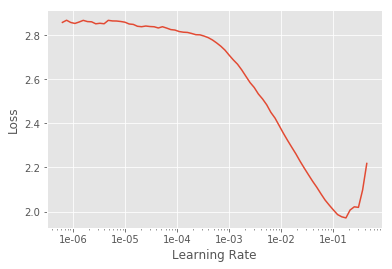

In [19]:
learner = cnn_learner(databunch, models.resnet34, 
                      metrics=[error_rate, accuracy], model_dir="/tmp/model/").to_fp16()
learner.lr_find();
learner.recorder.plot()

In [20]:
learner.fit_one_cycle(5, max_lr=slice(3e-02, 5e-03))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.576113,0.618979,0.217500,0.782500,01:43
1,0.491240,0.515433,0.189833,0.810167,01:18
2,0.444102,0.390627,0.147167,0.852833,01:17
3,0.367888,0.304293,0.112167,0.887833,01:17
4,0.338072,0.288235,0.108167,0.891833,01:20


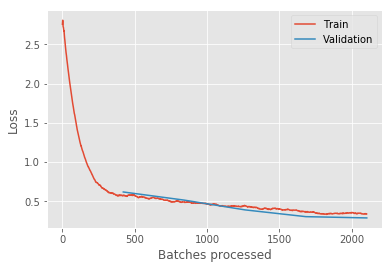

In [21]:
learner.recorder.plot_losses()

In [ ]:
learner.unfreeze()
learner.fit_one_cycle(5, max_lr=slice(3e-02))

In [23]:
learner.unfreeze()
learner.fit_one_cycle(5, max_lr=slice(3e-02))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.568262,0.521513,0.173500,0.826500,01:24
1,0.512649,0.478850,0.166333,0.833667,01:22
2,0.397548,0.373484,0.142167,0.857833,01:21
3,0.319852,0.260517,0.097500,0.902500,01:22
4,0.282017,0.235691,0.086500,0.913500,01:24


In [30]:
learner.save('stage-1-rn34')

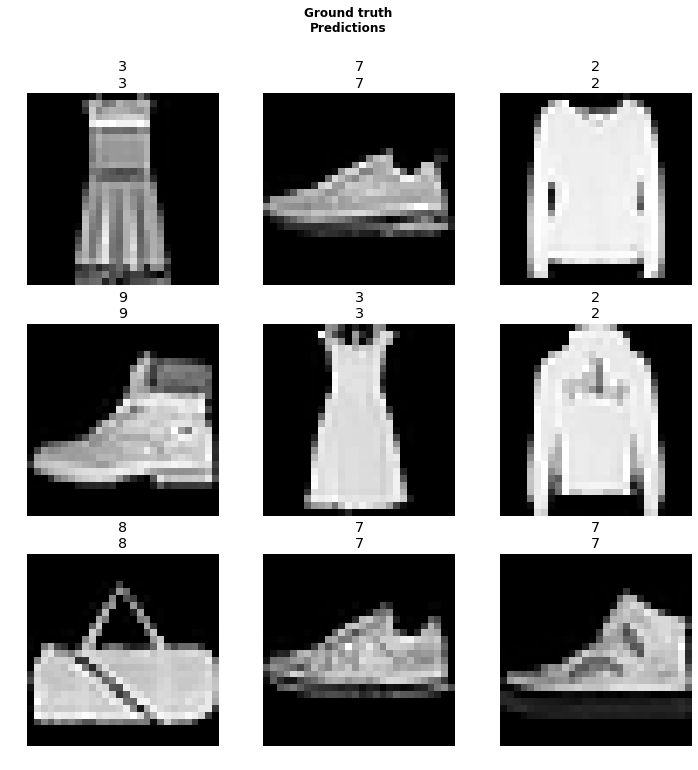

In [43]:
learner.show_results(rows=3)

In [41]:
interp = ClassificationInterpretation.from_learner(learner)
losses,idxs = interp.top_losses()
len(databunch.valid_ds)==len(losses)==len(idxs)

True

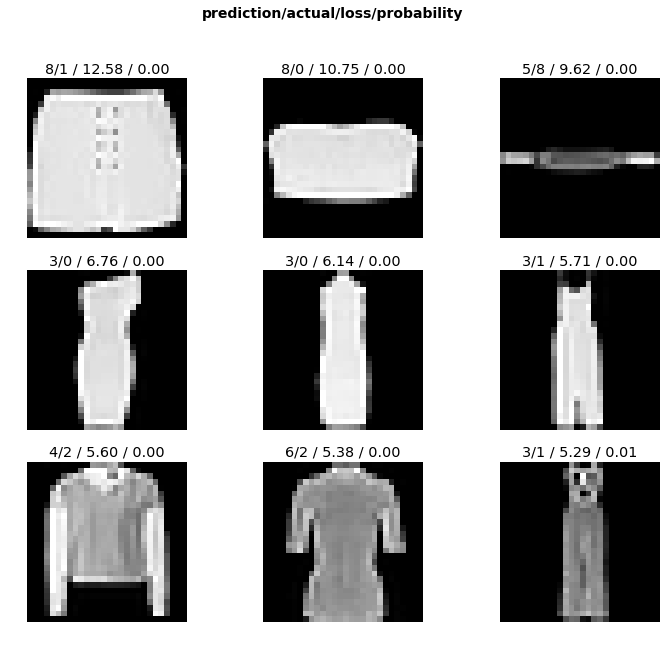

In [42]:
interp.plot_top_losses(9, figsize=(12,10), heatmap=False)

Model's confusion is real I think.

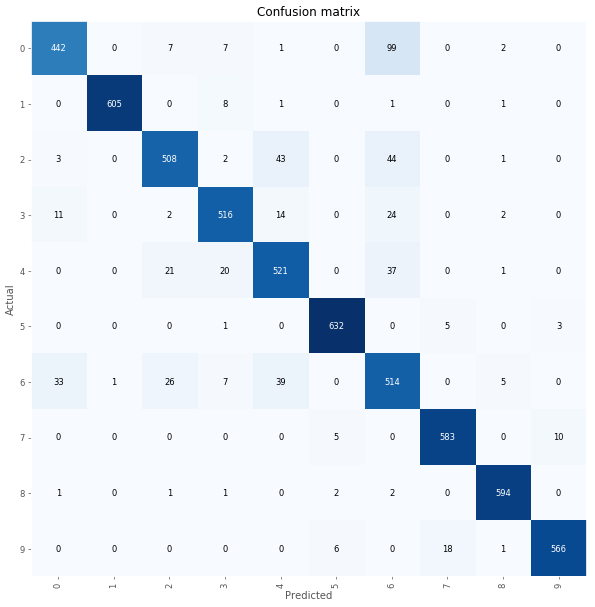

In [79]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [78]:
interp.most_confused(min_val=2)

[(0, 6, 99),
 (2, 6, 44),
 (2, 4, 43),
 (6, 4, 39),
 (4, 6, 37),
 (6, 0, 33),
 (6, 2, 26),
 (3, 6, 24),
 (4, 2, 21),
 (4, 3, 20),
 (9, 7, 18),
 (3, 4, 14),
 (3, 0, 11),
 (7, 9, 10),
 (1, 3, 8),
 (0, 2, 7),
 (0, 3, 7),
 (6, 3, 7),
 (9, 5, 6),
 (5, 7, 5),
 (6, 8, 5),
 (7, 5, 5),
 (2, 0, 3),
 (5, 9, 3),
 (0, 8, 2),
 (2, 3, 2),
 (3, 2, 2),
 (3, 8, 2),
 (8, 5, 2),
 (8, 6, 2)]

In [94]:
# !mkdir /kaggle/working/cleaned

mkdir: cannot create directory ‘/kaggle/working/cleaned’: File exists


In [95]:
from fastai.widgets import *

ds, idxs = DatasetFormatter().from_toplosses(learner, ds_type=DatasetType.Valid)
ImageCleaner(ds, idxs, Path('/kaggle/working/cleaned'))

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [177]:
cleaned = pd.read_csv('/kaggle/working/cleaned/cleaned.csv')
cleaned.head()

,name,label
0,../../input/train/train/1.png,9
1,../../input/train/train/2.png,0
2,../../input/train/train/3.png,0
3,../../input/train/train/4.png,3
4,../../input/train/train/5.png,0


In [178]:
import re

def clean_string(m):

    re1='.*?'	# Non-greedy match on filler
    re2='(\\d+)'	# Integer Number 1
    re3='(\\.)' 	# Any Single Character 1
    re4='(png)' 	# Word 1

    rg = re.compile(re1+re2+re3+re4,re.IGNORECASE|re.DOTALL)
    clean = rg.search(m)
    if m:
        int1=clean.group(1)
        c1=clean.group(2)
        word1=clean.group(3)
        return str(int1) + str(c1) + str(word1)

In [179]:
cleaned['name'] = cleaned.name.apply(clean_string)
cleaned.head()

,name,label
0,1.png,9
1,2.png,0
2,3.png,0
3,4.png,3
4,5.png,0


In [180]:
databunch = ImageList.from_df(cleaned, path=data_folder/'train', folder='train')\
            .split_by_rand_pct(0.1)\
            .label_from_df()\
            .add_test(test_img)\
            .transform(get_transforms(do_flip=True), size=28)\
            .databunch(path='.', bs=128, device= torch.device('cuda:0'))\
            .normalize(mnist_stats)

In [148]:
learner = cnn_learner(databunch, models.resnet34, 
                      metrics=[error_rate, accuracy], model_dir="/tmp/model/").to_fp16()

learner.load('stage-1-rn34')

learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.271711,0.222815,0.083333,0.916667,01:19
1,0.283718,0.222851,0.083148,0.916852,01:16
2,0.269298,0.228981,0.086296,0.913704,01:16
3,0.276371,0.224538,0.085000,0.915000,01:16
4,0.277172,0.221823,0.084259,0.915741,01:24


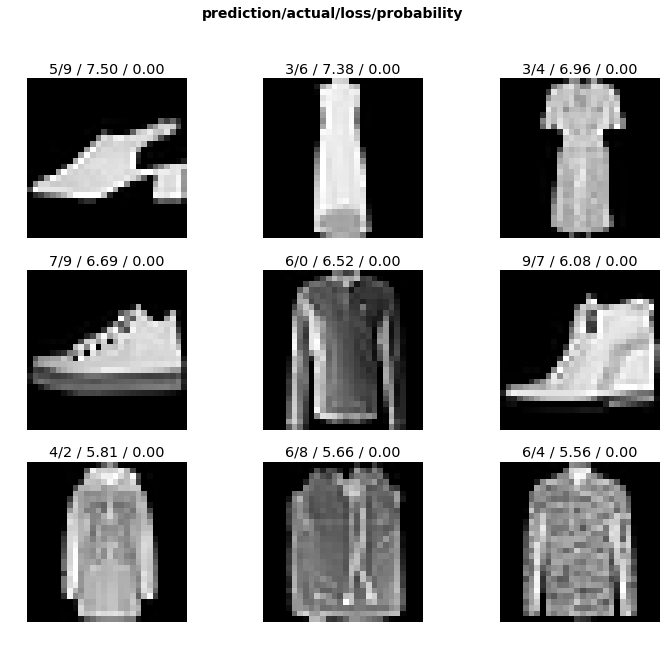

In [152]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_top_losses(9, figsize=(12,10), heatmap=False)

The effects of noise is quite vivid now. In this case, this is label noise. Take a look at the fourth and sixth figures. There are not pullovers or coats. They are labelled in the wrong way. Hence the model's accuracy is not improving that much. Another example is in second and third figures. From their shapes it is hard to distinguish between them. 

In [175]:
labels = []

for i in range(len(databunch.test_ds)):
    pred_class, _, _ = learner.predict(databunch.test_ds[i][0])
    labels.append(pred_class)
    
labels = list(map(lambda x: str(x).replace('Category', ''), labels))

sub_file['label'] = labels
sub_file.to_csv('submission.csv', index=False)

In [176]:
!head -5 submission.csv 

id,label
60001,9
60002,2
60003,1
60004,1
